# Evaluating Semantic Segmentation Models
> A guide for understanding the performance of semantic segmentation for land use / land cover in satellite imagery.

After we have trained a model for segmenting images according to a set of classes it's time to evaluate how well it has performed. With any supervised machine learning model, we are typically interested in minimizing false positives or false negatives, with a preference for one or the other. 

Additionally, are also interested in making sure our model generalizes beyond the training dataset to new data it was not trained on. Finally, we'd like our model to make high confidence, correct predictions, and for higher confidence thresholds to not result in many more false negatives.

For semantic segmentation, our evaluation unit is an individual pixel, which can be one of four categories:
* true positive: the pixel was classified correctly as a class of interest.
* true negative: the pixel was classified correctly as the background class.
* false positive: the pixel was incorrectly assigned a class of interest
* false negative: the pixel was incorrectly assigned the background class or a different class

The most in depth and succinct summary we can produce is a confusion matrix. It summarrizes the counts of pixels that fall into each of these categories for each of our classes of interest and the background class.


![Confusion Matrix Example](images/cm.png)

In this tutorial we will using data from two reference datasets, Imaflora and Para, and our U-Net predictions from Planet NICFI monthly imagery to compute a confusion matrix to assess our model performance. As we go through this exercise, you'll notice that our reference datasets do not always correspond to the imagery, so take this lesson as a demonstration of how to carry out an experiment, not as an evaluation of a model that will be used in production. The next episode will cover how to deal with innacurate or limited reference data.

## Specific concepts that will be covered
In the process, we will build practical experience and develop intuition around the following concepts:
* **[sci-kit learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)** - we will use sci-kit learn to compute a confusion matrix and discuss how supplying different values to the `normalize `argument can help us interpret our data. 
* **Metrics** - We will cover useful summary metrics that capture much of the information in the confusion matrix, including precision, recall, and F1 Score.


**Audience:** This post is geared towards intermediate users who are comfortable with basic machine learning concepts. 

**Time Estimated**: 60-120 min



## Setup Notebook

In [ ]:
# install required libraries
!pip install -q rasterio==1.2.10
!pip install -q geopandas==0.10.2
!pip install -q git+https://github.com/tensorflow/examples.git
!pip install -q -U tfds-nightly
!pip install -q focal-loss
!pip install -q tensorflow-addons==0.8.3
#!pip install -q matplotlib==3.5 # UNCOMMENT if running on LOCAL
!pip install -q scikit-learn==1.0.1
!pip install -q scikit-image==0.18.3

In [1]:
# import required libraries
import os, glob, functools, fnmatch
from zipfile import ZipFile
from itertools import product

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image
import geopandas as gpd
from IPython.display import clear_output
from time import sleep

import skimage.io as skio # lighter dependency than tensorflow for working with our tensors/arrays
from sklearn.metrics import confusion_matrix, f1_score

### Getting set up with the data

```{important}
Create drive shortcuts of the tiled imagery to your own My Drive Folder by Right-Clicking on the Shared folder `servir-tf-devseed`. Then, this folder will be available at the following path that is accessible with the google.colab `drive` module: `'/content/gdrive/My Drive/servir-tf-devseed/'`
```

We'll be working witht he following folders in the `servir-tf-devseed` folder:
```
servir-tf-devseed/
├── images/
├── images_bright/
├── indices/
├── indices_800/
├── labels/
├── labels_800/
├── background_list_train.txt
├── train_list_clean.txt
└── terrabio_classes.csv
```

In [2]:
# set your root directory and tiled data folders
if 'google.colab' in str(get_ipython()):
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    root_dir = '/content/gdrive/My Drive/servir-tf-devseed/' 
    workshop_dir = '/content/gdrive/My Drive/servir-tf-devseed-workshop'
    print('Running on Colab')
else:
    root_dir = os.path.abspath("./data/servir-tf-devseed")
    workshop_dir = os.path.abspath('./servir-tf-devseed-workshop')
    print(f'Not running on Colab, data needs to be downloaded locally at {os.path.abspath(root_dir)}')

img_dir = os.path.join(root_dir,'indices/') # or os.path.join(root_dir,'images_bright/') if using the optical tiles
label_dir = os.path.join(root_dir,'labels/')

Not running on Colab, data needs to be downloaded locally at /home/rave/servir-amazonia-ml/ds_book/docs/data/servir-tf-devseed


In [3]:
# go to root directory
%cd $root_dir 

/home/rave/servir-amazonia-ml/ds_book/docs/data/servir-tf-devseed


### Check out the labels
We'll use these labels to label our confusion matrix and table with class specific metrics.

In [4]:
# Read the classes
class_index = pd.read_csv(os.path.join(root_dir,'terrabio_classes.csv'))
class_names = class_index.class_name.unique()
print(class_index) 


   class_id   class_name
0         0   Background
1         1     Bushland
2         2      Pasture
3         3        Roads
4         4        Cocoa
5         5   Tree cover
6         6    Developed
7         7        Water
8         8  Agriculture


### Getting image, prediction, and label filenames

Before creating our confusion matrix, we need to associate labels, images, and prediction files together so that we know what to compare. We'll use our standard python for this.

### Evaluate Model

Compute confusion matrix from all predicted images and their ground truth label masks. 

First we need to read in our prediction masks that we saved out in the last notebook. To do this, we can use scikit image, and then we can use scikit learn to compute our confusion matrix. No tensorflow needed for this part!

In [5]:
path_df = pd.read_csv(os.path.join(root_dir, "test_file_paths.csv"))

In [6]:
pd.set_option('display.max_colwidth', None)
path_df

,Unnamed: 0,img_names,label_names,pred_names
0,0,/Users/rave/servir-amazonia-ml/ds_book/docs/data/servir-tf-devseed/indices/tile_terrabio_392.png,/Users/rave/servir-amazonia-ml/ds_book/docs/data/servir-tf-devseed/labels/tile_terrabio_392.png,/Users/rave/servir-amazonia-ml/ds_book/docs/servir-tf-devseed-workshop/predictions_test_focal_loss/tile_terrabio_392.png
1,1,/Users/rave/servir-amazonia-ml/ds_book/docs/data/servir-tf-devseed/indices/tile_terrabio_1440.png,/Users/rave/servir-amazonia-ml/ds_book/docs/data/servir-tf-devseed/labels/tile_terrabio_1440.png,/Users/rave/servir-amazonia-ml/ds_book/docs/servir-tf-devseed-workshop/predictions_test_focal_loss/tile_terrabio_1440.png
2,2,/Users/rave/servir-amazonia-ml/ds_book/docs/data/servir-tf-devseed/indices/tile_terrabio_21138.png,/Users/rave/servir-amazonia-ml/ds_book/docs/data/servir-tf-devseed/labels/tile_terrabio_21138.png,/Users/rave/servir-amazonia-ml/ds_book/docs/servir-tf-devseed-workshop/predictions_test_focal_loss/tile_terrabio_21138.png
3,3,/Users/rave/servir-amazonia-ml/ds_book/docs/data/servir-tf-devseed/indices/tile_terrabio_21426.png,/Users/rave/servir-amazonia-ml/ds_book/docs/data/servir-tf-devseed/labels/tile_terrabio_21426.png,/Users/rave/servir-amazonia-ml/ds_book/docs/servir-tf-devseed-workshop/predictions_test_focal_loss/tile_terrabio_21426.png
4,4,/Users/rave/servir-amazonia-ml/ds_book/docs/data/servir-tf-devseed/indices/tile_terrabio_3724.png,/Users/rave/servir-amazonia-ml/ds_book/docs/data/servir-tf-devseed/labels/tile_terrabio_3724.png,/Users/rave/servir-amazonia-ml/ds_book/docs/servir-tf-devseed-workshop/predictions_test_focal_loss/tile_terrabio_3724.png
...,...,...,...,...
442,442,/Users/rave/servir-amazonia-ml/ds_book/docs/data/servir-tf-devseed/indices/tile_terrabio_52.png,/Users/rave/servir-amazonia-ml/ds_book/docs/data/servir-tf-devseed/labels/tile_terrabio_52.png,/Users/rave/servir-amazonia-ml/ds_book/docs/servir-tf-devseed-workshop/predictions_test_focal_loss/tile_terrabio_52.png
443,443,/Users/rave/servir-amazonia-ml/ds_book/docs/data/servir-tf-devseed/indices/tile_terrabio_95.png,/Users/rave/servir-amazonia-ml/ds_book/docs/data/servir-tf-devseed/labels/tile_terrabio_95.png,/Users/rave/servir-amazonia-ml/ds_book/docs/servir-tf-devseed-workshop/predictions_test_focal_loss/tile_terrabio_95.png
444,444,/Users/rave/servir-amazonia-ml/ds_book/docs/data/servir-tf-devseed/indices/tile_terrabio_2678.png,/Users/rave/servir-amazonia-ml/ds_book/docs/data/servir-tf-devseed/labels/tile_terrabio_2678.png,/Users/rave/servir-amazonia-ml/ds_book/docs/servir-tf-devseed-workshop/predictions_test_focal_loss/tile_terrabio_2678.png
445,445,/Users/rave/servir-amazonia-ml/ds_book/docs/data/servir-tf-devseed/indices/tile_terrabio_44.png,/Users/rave/servir-amazonia-ml/ds_book/docs/data/servir-tf-devseed/labels/tile_terrabio_44.png,/Users/rave/servir-amazonia-ml/ds_book/docs/servir-tf-devseed-workshop/predictions_test_focal_loss/tile_terrabio_44.png


In [7]:
# reading in preds
label_arr_lst = path_df["label_names"].apply(skio.imread)
pred_arr_lst = path_df["pred_names"].apply(skio.imread)

One of our labels has an image dimension that doesn't match the prediction dimension! It's possible this image was corrupted. We can skip it and the corresponding prediction when computing our metrics.

In [8]:
pred_arr_lst_valid = []
label_arr_lst_valid = []
for i in range(0, len(pred_arr_lst)):
    if pred_arr_lst[i].shape != label_arr_lst[i].shape:
        
        print(f"The {i}th label has an incorrect dimension, skipping.")
        print(pred_arr_lst[i])
        print(label_arr_lst[i])
        print(pred_arr_lst[i].shape)
        print(label_arr_lst[i].shape)
        
    else:
        pred_arr_lst_valid.append(pred_arr_lst[i])
        label_arr_lst_valid.append(label_arr_lst[i])

The 176th label has an incorrect dimension, skipping.
[[5 0 5 ... 6 5 0]
 [3 2 4 ... 7 4 7]
 [5 1 4 ... 5 5 3]
 ...
 [4 7 4 ... 7 4 7]
 [5 1 2 ... 5 5 1]
 [4 2 4 ... 2 4 2]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(224, 224)
(218, 224)


With our predictions and labels in lists of tiled arrays, we can then flatten these so that we instead have lists of pixels for predictions and labels. This is the format expected by scikit-learn's `confusion_matrix` function.

In [9]:
# flatten our tensors and use scikit-learn to create a confusion matrix
flat_preds = np.concatenate(pred_arr_lst_valid).flatten()
flat_truth = np.concatenate(label_arr_lst_valid).flatten()
OUTPUT_CHANNELS = 9
cm = confusion_matrix(flat_truth, flat_preds, labels=list(range(OUTPUT_CHANNELS)))

Finally, we can plot the confusion matrix. We can either use the built-in method from scikit-learn... 

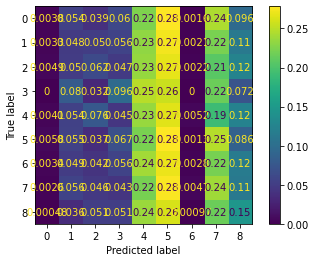

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(flat_truth, flat_preds, normalize='true')

... or matplotlib, which allows us to more easily customize all aspects of our plot.

(8.5, -0.5)

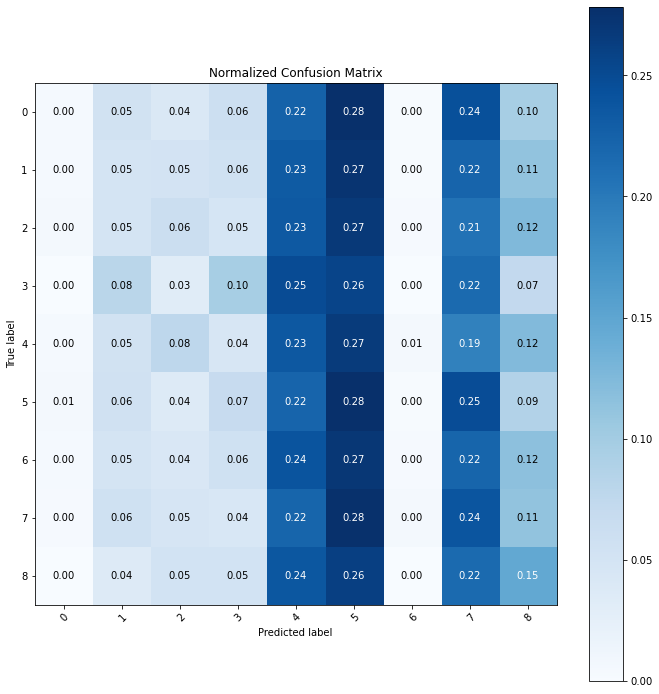

In [15]:
classes = [0,1,2,3,4,5,6,7,8]

%matplotlib inline
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=list(range(OUTPUT_CHANNELS)), yticklabels=list(range(OUTPUT_CHANNELS)),
       title='Normalized Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = '.2f' #'d' # if normalize else 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout(pad=2.0, h_pad=2.0, w_pad=2.0)
ax.set_ylim(len(classes)-0.5, -0.5)

Now let's compute the f1 score

F1 = 2 * (precision * recall) / (precision + recall)


You can view the documentation for a python function in a jupyter notebook with "??". scikit-learn docs usually come with detaile descriptions of each argument and examples of usage.

In [ ]:
f1_score??

In [ ]:
# compute f1 score
f1_score(flat_truth, flat_preds, average='macro')